# Importing 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
device = torch.device('cuda:0')
print(device)

cuda:0


# Loading Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])

In [4]:
trainset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Covid train test/train',transform = transform)
testset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Covid train test/test',transform = transform)

# CNN Architecture

In [5]:
class FirstCNN(nn.Module):

  def __init__(self):
    super(FirstCNN,self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(3,32,3), # (N,3,224,224) --> (N,32,222,222)
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.MaxPool2d(2,2), #(N,32,111,111)
        
        nn.Conv2d(32,32,3), # (N,32,111,111) --> (N,32,109,109)
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.MaxPool2d(2,2), #(N,32,54,54)
        
        nn.Conv2d(32,64,3), #(N,32,54,54) --> (N,64,52,52)
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(64,250,3), #(N,250,50,50)
        nn.BatchNorm2d(250),
        nn.LeakyReLU(),
        nn.Conv2d(250,128,3), #(N,128,48,48)
        nn.BatchNorm2d(128),
        nn.AvgPool2d(2,2), #(N,128,24,24)
        
        
        nn.Conv2d(128,64,3), #(N,64,22,22)
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.AvgPool2d(2,2), #(N,64,11,11)
        
        
        nn.Conv2d(64,256,3), #(N,256,9,9)
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.MaxPool2d(2,2), #(N,256,4,4)

        
    )
    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096,32),
        nn.LeakyReLU(),
        nn.Dropout(0.5),
        nn.Linear(32,2),
        

    )

    

  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    return x

In [6]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)
      


      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


In [7]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = np.ceil(2300/128)
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 10 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
      
  print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')

  plt.plot(loss_arr)
  plt.show()

    
  

# Training the Model

Epoch:1: Iteration 0/18.0: Loss: 0.9892250299453735
Epoch:1: Iteration 10/18.0: Loss: 0.1792677342891693
Epoch:2: Iteration 0/18.0: Loss: 0.15349864959716797
Epoch:2: Iteration 10/18.0: Loss: 0.07752306759357452
Epoch:3: Iteration 0/18.0: Loss: 0.034246888011693954
Epoch:3: Iteration 10/18.0: Loss: 0.05902902036905289
Epoch:4: Iteration 0/18.0: Loss: 0.050324518233537674
Epoch:4: Iteration 10/18.0: Loss: 0.027285628020763397
Epoch:5: Iteration 0/18.0: Loss: 0.05666877329349518
Epoch:5: Iteration 10/18.0: Loss: 0.04152077063918114
Epoch:6: Iteration 0/18.0: Loss: 0.01763603277504444
Epoch:6: Iteration 10/18.0: Loss: 0.034923650324344635
Epoch:7: Iteration 0/18.0: Loss: 0.028434637933969498
Epoch:7: Iteration 10/18.0: Loss: 0.04037858173251152
Epoch:8: Iteration 0/18.0: Loss: 0.024854693561792374
Epoch:8: Iteration 10/18.0: Loss: 0.018005099147558212
Epoch:9: Iteration 0/18.0: Loss: 0.023456253111362457
Epoch:9: Iteration 10/18.0: Loss: 0.027789143845438957
Epoch:10: Iteration 0/18.0: Lo

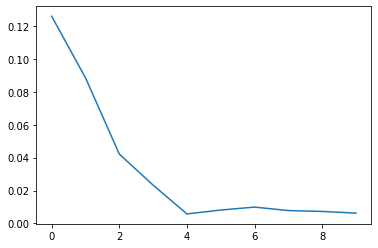

In [8]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)
net = FirstCNN()
net = net.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(),lr = 0.0001)
fit(10,loss_fn,opt,net)

It is observed that it is very easy to do binary classification of COVID from X-ray. (NORMAL or COVID) using the model proposed above. This works with great accuracy. 